<h1>Analysis of bus public transport in Malaga using graphs</h1>
<h2>Learning from Networks 2022-23</h2>
<p>Project developed by Jesús Moncada Ramírez</p>

<h1>1. Importing the datasets

In [21]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_stops = pd.read_csv('dataset/stops.csv', error_bad_lines=False)
df_stop_times = pd.read_csv('dataset/stop_times.csv', error_bad_lines=False)
df_routes = pd.read_csv('dataset/routes.csv', error_bad_lines=False)
df_trips = pd.read_csv('dataset/trips.csv', error_bad_lines=False)
df_shapes = pd.read_csv('dataset/shapes.csv', error_bad_lines=False)
df_lines_stops = pd.read_csv('dataset/lines_and_stops.csv', error_bad_lines=False, usecols=['codLinea', 'userCodLinea', 'nombreLinea', 'sentido', 'orden', 'codParada', 'nombreParada', 'lon', 'lat'])

In order to translate some columns names from spanish to english, we will apply a <code>rename</code> operation over some of the datasets.

In [3]:
rename_dict = {'codLinea':'line_code', 
               'userCodLinea':'line_label',
               'nombreLinea':'line_name',
               'sentido':'line_direction',
               'orden':'stop_order',
               'codParada':'stop_code',
               'nombreParada':'stop_name',
               'lon':'stop_lon',
               'lat':'stop_lat'}

df_lines_stops.rename(columns = rename_dict, inplace=True)

We can also change the data type of somes columns to adjust to our problem.

In [4]:
convert_dict = {'line_code':int, 'line_direction':int}

df_lines_stops = df_lines_stops.astype(convert_dict)

Now we cand describe the CSV files imported to discover info about them.

In [5]:
def describe_dataframe(data_name, data, show=5):
    print("--- {0} ---".format(data_name))
    print("Number of elements: {0}".format(len(data)))
    print(data.head(show))

In [6]:
describe_dataframe('STOPS', df_stops)

--- STOPS ---
Number of elements: 1088
   stop_id  stop_code                      stop_name   stop_lat  stop_lon  \
0      103        103  Victoria (Plaza de la Merced)  36.723415 -4.416463   
1      104        104          Compás de la Victoria  36.727403 -4.413547   
2      105        105           Fernando el Católico  36.729034 -4.413708   
3      106        106          Cristo de la Epidemia  36.731038 -4.415068   
4      107        107        Plaza de Fuente Olletas  36.732988 -4.416382   

                                            stop_url  
0  http://www.emtmalaga.es/emt-mobile/informacion...  
1  http://www.emtmalaga.es/emt-mobile/informacion...  
2  http://www.emtmalaga.es/emt-mobile/informacion...  
3  http://www.emtmalaga.es/emt-mobile/informacion...  
4  http://www.emtmalaga.es/emt-mobile/informacion...  


In [7]:
describe_dataframe('STOP_TIMES', df_stop_times)

--- STOP_TIMES ---
Number of elements: 226398
     trip_id arrival_time departure_time  stop_id  stop_sequence
0  10L7S1V19     24:37:00       24:37:00      755             35
1  10L7S1V19     24:35:00       24:35:00      710             34
2  10L7S1V19     24:34:00       24:34:00      608             33
3  10L7S1V19     24:33:00       24:33:00      709             32
4  10L7S1V19     24:32:00       24:32:00      707             31


In [8]:
describe_dataframe('ROUTES', df_routes)

--- ROUTES ---
Number of elements: 47
   route_id route_short_name  \
0         1                1   
1         2                2   
2         3                3   
3         4                4   
4         5                5   

                                     route_long_name  route_type  \
0    Parque del Sur - Alameda Principal - San Andrés           3   
1                  Alameda Principal - Ciudad Jardín           3   
2  Puerta Blanca - Alameda Principal - El Palo (O...           3   
3  Paseo del Parque - Cruz Humilladero - Cortijo ...           3   
4     Alameda Principal - Guadalmar - Parque de Ocio           3   

                                           route_url  
0  http://www.emtmalaga.es/emt-mobile/informacion...  
1  http://www.emtmalaga.es/emt-mobile/informacion...  
2  http://www.emtmalaga.es/emt-mobile/informacion...  
3  http://www.emtmalaga.es/emt-mobile/informacion...  
4  http://www.emtmalaga.es/emt-mobile/informacion...  


In [9]:
describe_dataframe('TRIPS', df_trips)

--- TRIPS ---
Number of elements: 8391
   route_id service_id  trip_id   trip_headsign  direction_id shape_id
0         1         LN  0L1S1V1      San Andrés             0     1IDA
1         1         LN  0L1S1V2  Parque del Sur             1     1VTA
2         1         LN  0L1S1V3      San Andrés             0     1IDA
3         1         LN  0L1S1V4  Parque del Sur             1     1VTA
4         1         LN  0L1S1V5      San Andrés             0     1IDA


In [10]:
describe_dataframe('SHAPES', df_shapes)

--- SHAPES ---
Number of elements: 24381
  shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence
0     1IDA     36.737774     -4.422069                  0
1     1IDA     36.737851     -4.422428                  1
2     1IDA     36.737892     -4.422732                  2
3     1IDA     36.737882     -4.422866                  3
4     1IDA     36.737845     -4.422910                  4


In [11]:
describe_dataframe('LINES_STOPS', df_lines_stops)

--- LINES_STOPS ---
Number of elements: 2328
   line_code line_label                                        line_name  \
0          1          1  Parque del Sur - Alameda Principal - San Andrés   
1          1          1  Parque del Sur - Alameda Principal - San Andrés   
2          1          1  Parque del Sur - Alameda Principal - San Andrés   
3          1          1  Parque del Sur - Alameda Principal - San Andrés   
4          1          1  Parque del Sur - Alameda Principal - San Andrés   

   line_direction  stop_order  stop_code                           stop_name  \
0               1           1        152  Av. de las Postas - Lorenza Correa   
1               1           2        153                         Emilio Díaz   
2               1           3        154            San Juan Bosco - Albéniz   
3               1           4        155          San Juan Bosco - Segalerva   
4               1           5       1354             Eduardo Domínguez Ávila   

   stop_lon   sto

<h1>2. Creating the graph</h2>

As there are several inconsistences in the datasets (e.g. the number of lines in <code>routes.csv</code> is not the same as the number of lines in <code>lines_and_stops.csv</code>) we will use the file <code>lines_and_stops.csv</code> to build the graph, and the rest of files for extra information.

We have to create a directed graph, due to the two directions of the bus lines.

In [12]:
G = nx.DiGraph()

<h2>2.1. Adding the nodes</h2>

First of all, let's add all the nodes (stops).

In [13]:
col_target = ['stop_code', 'stop_name', 'stop_lon', 'stop_lat']

stops = df_lines_stops.drop_duplicates('stop_code')[col_target]

describe_dataframe('PROCESSED STOPS', stops)

for index, stop in stops.iterrows():
    G.add_node(stop['stop_code'], name=stop['stop_name'], lat=stop['stop_lat'], lon=stop['stop_lon'])
    
#print(G.nodes())

--- PROCESSED STOPS ---
Number of elements: 1116
   stop_code                           stop_name  stop_lon   stop_lat
0        152  Av. de las Postas - Lorenza Correa -4.422251  36.737835
1        153                         Emilio Díaz -4.423585  36.735730
2        154            San Juan Bosco - Albéniz -4.422321  36.734028
3        155          San Juan Bosco - Segalerva -4.421849  36.732384
4       1354             Eduardo Domínguez Ávila -4.421500  36.730183


<h2>2.2 Adding the edges</h2>

In order to add the edges we have to iterate thorugh every line. For every line we have to iterate through all the stops of that line, and for every connection between two stops create an edge.

Note that every line has an identifier <code>line_code</code> that we will use to identify the lines in our data structures, and a label <code>line_label</code>, which is the formal name of the line, known by every people using the public transport.

In [14]:
unique_lines = df_lines_stops['line_code'].unique()

for line in unique_lines:
    for direction in [1, 2]:
        #print("line {0}; direction {1}".format(line, direction))
        data = (df_lines_stops.loc[(df_lines_stops['line_code'] == line) &
                                 (df_lines_stops['line_direction'] == direction)])
        
        previous_stop = None
        actual_stop = None
        for index, step in data.iterrows():
            previous_stop = actual_stop
            actual_stop = step['stop_code']
            #print("pre {0}; act {1}".format(previous_stop, actual_stop))
            
            if previous_stop is not None and actual_stop is not None:
                G.add_edge(previous_stop, actual_stop, line=line, direction=direction, velocity=0.0)

<h2>2.3. Displaying it graphically</h2>

First of all we will have to assign a color to each node (stop) and edge (connection between stops) in the graph. The color of a stop will be black, and won't depend on the lines, as a stop can belong to several bus lines. On the other hand, each line will have a color, so the edges beloging to this line will be all of the same color. These colors are chosen at random.

In [15]:
line_color_dict = {}

for line in unique_lines:
    line_color_dict[line] = tuple(np.random.random(3))

edge_color = []

for u, v, data in G.edges(data=True):
    edge_color.append(line_color_dict[data['line']])

Now we have to create a dictionary with the position of every node, <code>positions</code>.

In [16]:
positions = {}

for stop_line, data in G.nodes(data=True):
    positions[stop_line] = [data['lon'], data['lat']]

Now we can display all the nodes in the graph.

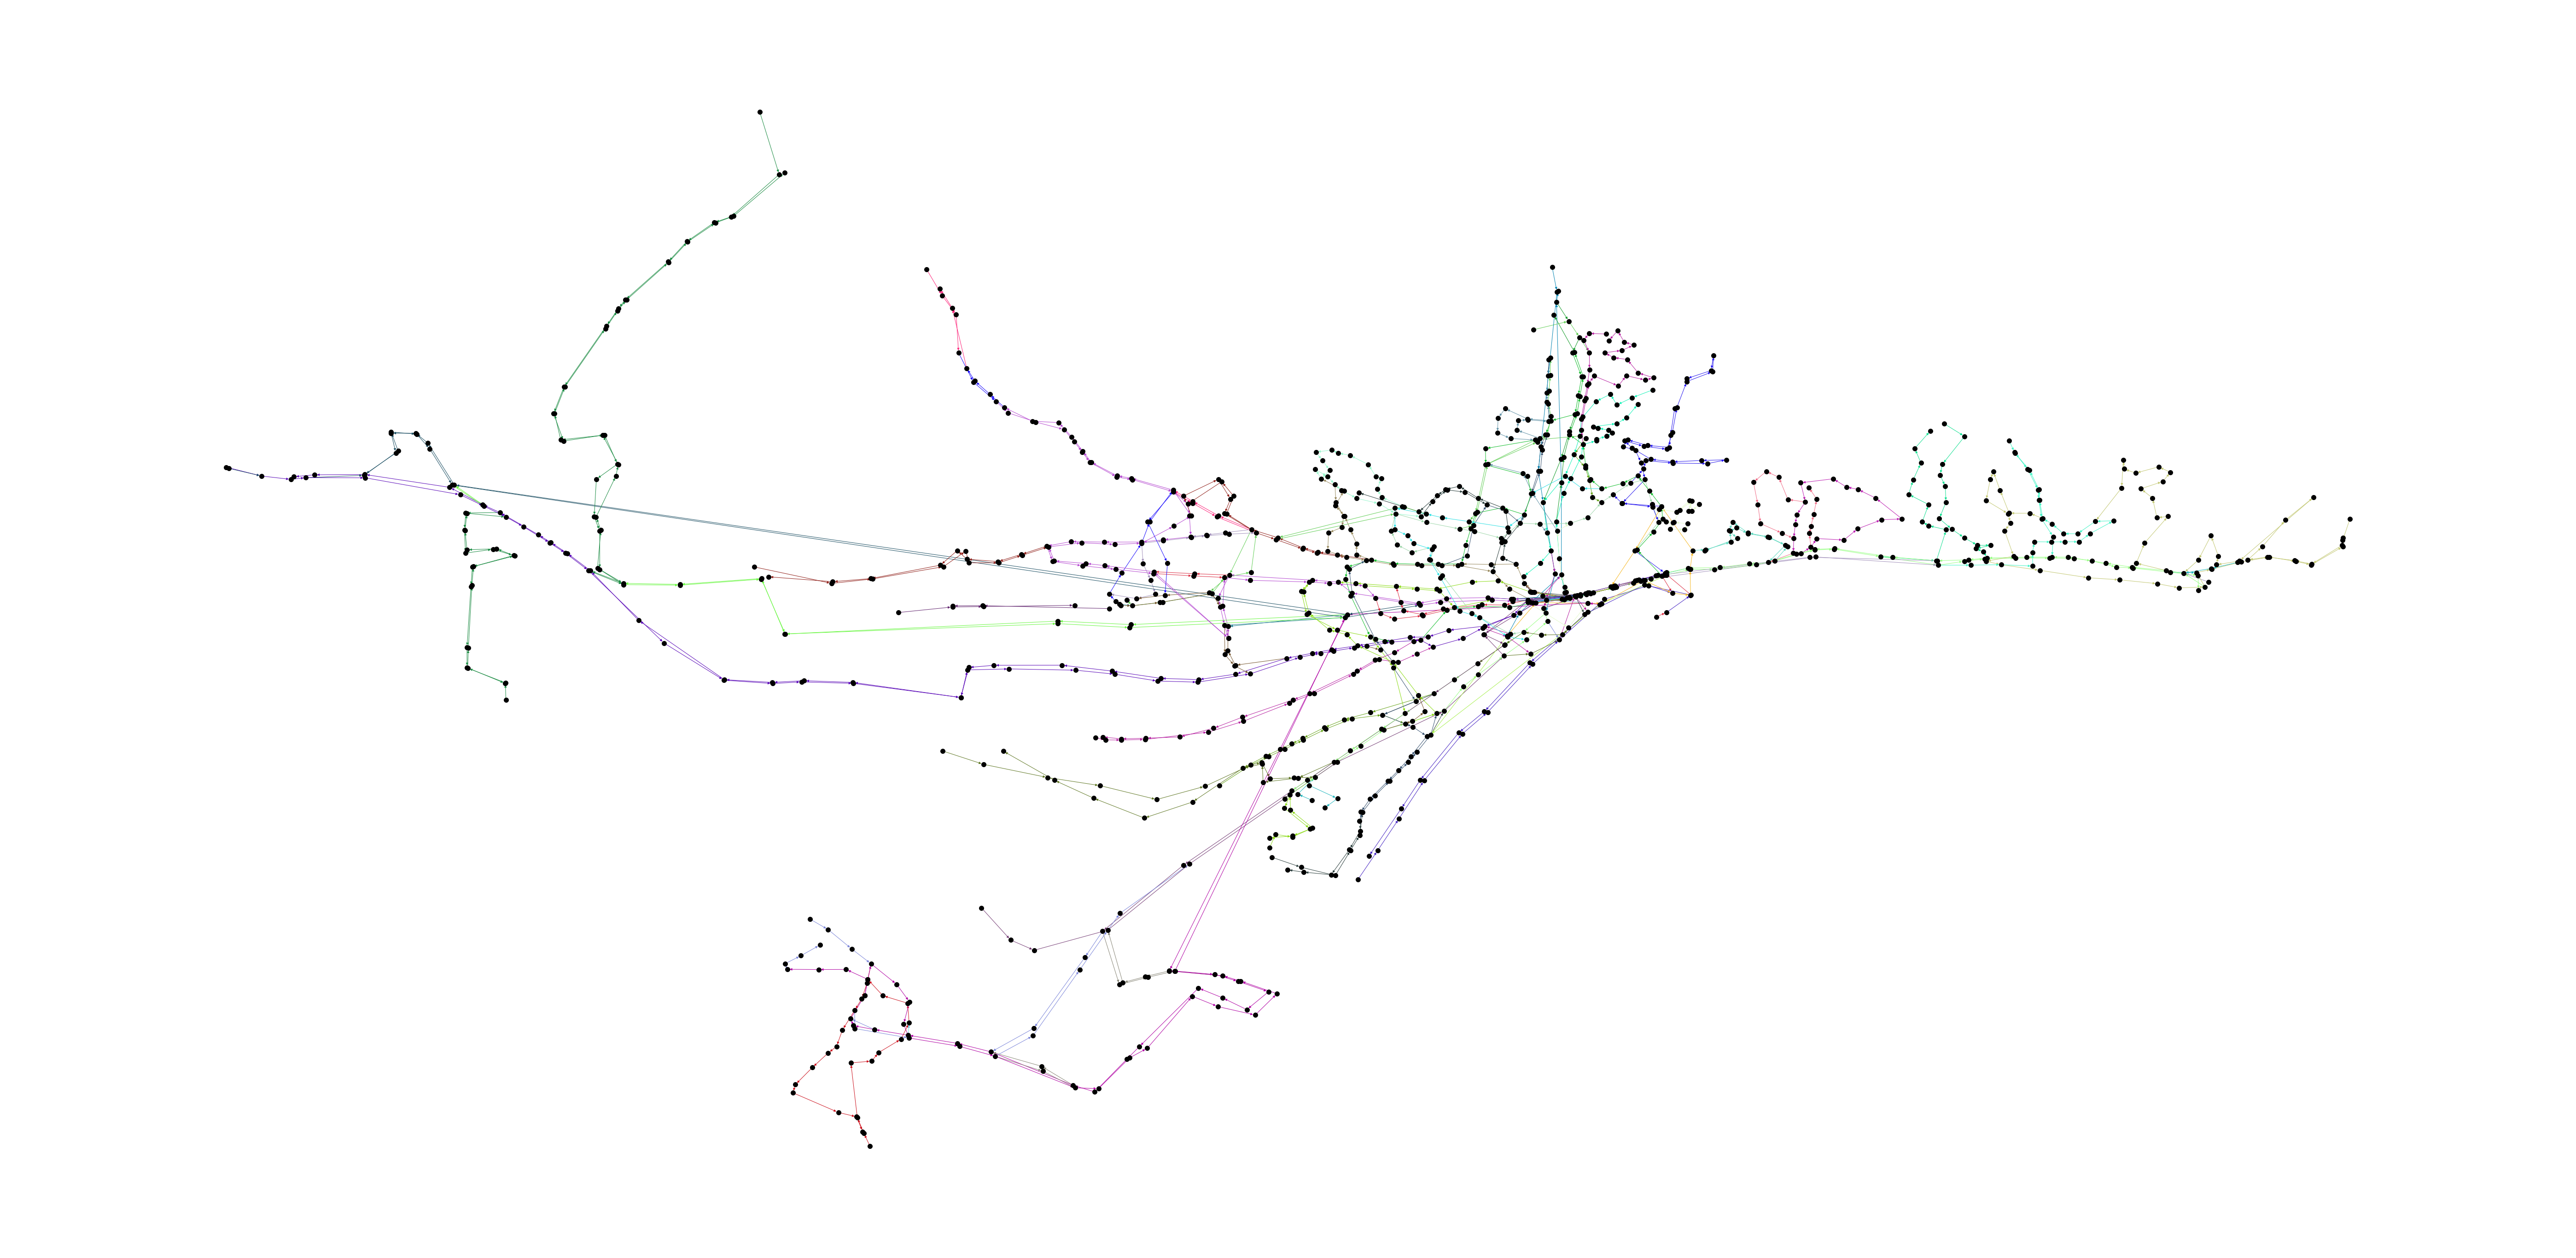

In [20]:
fig, ax = plt.subplots(figsize = (100,50))

nx.draw(G,
        pos         = positions,
        node_color = 'black',
        edge_color = edge_color,
        font_size   = 10,
        node_size   = 100)

<h3>2.3.1. Displaying it graphically with Mplleaflet (optional)</h3>

The Python library Mplleaflet allows to show Matplotlib drawings on an interactive map based on Open Street Map or other map services. The result is a webpage, which can be embedded into an Jupyter notebook.

Unfortunately, there are bugs in the library that haven't been solved yet, like <a href="https://stackoverflow.com/questions/60603427/problems-plotting-on-mplleaflet-using-networkx-and-python">this one</a> that I encountered during the development of the project. To solve it I had to downgrade <code>matplotlib</code> to version 3.3.2 (<a href="https://lightrun.com/answers/jwass-mplleaflet-_gridonmajor-bug-with-recent-versions-of-matplotlib">following this link</a>) and edit the source code of the <code>Mplleaflet</code> library. Specifically, the file <code>mplleaflet/utils.py</code> substituting the line:

<code>elif code == 'L':</code>

by:

<code>elif code == 'L' or code == 'S' or code == 'Z':</code>

Even so, the results aren't as good as expected. Executing the cells of code below you can observe that the edges of the graph appear lightly moved to their original position (in the previous image). Because of that, after watching the results, this section has been classified as optional, like an extended feature that can be computed to test.

In [ ]:
#import mplleaflet

In [26]:
#mplleaflet.show(fig = ax.figure, path='generated_map.html')

The map generated will also be saved into a file for posterior visualization (<code>generated_map.html</code>). 